In this short demo, we studies the different strategies of market makers, using **pyspark** > 2.4.4 and **LOBSTER** data constructed by the new **LOBSTER** engine running on cloud setting.

## Prerequisite Packages
Several packages need to be installed:
1. **pyspark** or a full **spark** installation following [here] <https://spark.apache.org/downloads.html>. 
1. **numpy** and **pandas** as expected
1. **seabon** for graphic presentation
1. **pyarrow** is **NOT** required in current stage, but better to get it ready.

In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import date

sns.set()
pd.options.display.max_columns = None

%matplotlib inline

## Initialize Spark 
Note that although **Apache Arrow** is a powerful tool to accelerate the convertion between spark dataframe and pandas dataframe, it hit a problem when there is a ``date`` column in the data set. Therefore, I have to disable the feature.

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Load data") \
    .config("spark.driver.memory", "4G") \
    .config("spark.sql.execution.arrow.enabled", "false") \
    .getOrCreate()

## Specify the data path
The data are currently shared through Dropbox. It includes NASDAQ 100 stocks (On-going constructing)
1. All orders since the platform in NASDAQ is initialize at c.a. 4:00 until shut down at c.a. 20:00 
2. Reconstructed 10-level order books in the same time period

In [3]:
import os

HOME = os.environ["HOME"]
dataRoot = os.path.join(HOME, "Dropbox", "LobsterOnSpark")
messageRootDir = os.path.join(dataRoot, "message")
orderBookRootDir = os.path.join(dataRoot, "orderBook", "level=10")

In [4]:
messageDf = spark.read.parquet(messageRootDir)
orderBookDf = spark.read.parquet(orderBookRootDir)

Investigate the schemas and some data

In [5]:
messageDf.printSchema()

root
 |-- time: long (nullable = true)
 |-- eventType: string (nullable = true)
 |-- sequenceNumber: long (nullable = true)
 |-- orderId: string (nullable = true)
 |-- side: string (nullable = true)
 |-- effectiveQuantity: long (nullable = true)
 |-- effectivePrice: long (nullable = true)
 |-- attribution: string (nullable = true)
 |-- matchNumber: long (nullable = true)
 |-- date: date (nullable = true)
 |-- symbol: string (nullable = true)



In [6]:
messageDf.limit(5).toPandas().head()

,time,eventType,sequenceNumber,orderId,side,effectiveQuantity,effectivePrice,attribution,matchNumber,date,symbol
0,14400013956117,Submission,570,12801,Buy,33,2992900,,0,2020-02-03,AAPL
1,14400020339835,Submission,580,14929,Buy,70,3127000,,0,2020-02-03,AAPL
2,14400536622555,Submission,590,54009,Buy,1,2980000,,0,2020-02-03,AAPL
3,14400875546221,Submission,600,58665,Buy,300,3098000,,0,2020-02-03,AAPL
4,14400875730433,Submission,610,58669,Buy,200,3092000,,0,2020-02-03,AAPL


In [7]:
orderBookDf.printSchema()

root
 |-- sequenceNumber: long (nullable = true)
 |-- timestamp: double (nullable = true)
 |-- Bid_10_price: double (nullable = true)
 |-- Bid_10_quantity: double (nullable = true)
 |-- Bid_1_price: double (nullable = true)
 |-- Bid_1_quantity: double (nullable = true)
 |-- Bid_2_price: double (nullable = true)
 |-- Bid_2_quantity: double (nullable = true)
 |-- Bid_3_price: double (nullable = true)
 |-- Bid_3_quantity: double (nullable = true)
 |-- Bid_4_price: double (nullable = true)
 |-- Bid_4_quantity: double (nullable = true)
 |-- Bid_5_price: double (nullable = true)
 |-- Bid_5_quantity: double (nullable = true)
 |-- Bid_6_price: double (nullable = true)
 |-- Bid_6_quantity: double (nullable = true)
 |-- Bid_7_price: double (nullable = true)
 |-- Bid_7_quantity: double (nullable = true)
 |-- Bid_8_price: double (nullable = true)
 |-- Bid_8_quantity: double (nullable = true)
 |-- Bid_9_price: double (nullable = true)
 |-- Bid_9_quantity: double (nullable = true)
 |-- Offer_10_pric

In [8]:
orderBookDf.limit(5).toPandas().head()

,sequenceNumber,timestamp,Bid_10_price,Bid_10_quantity,Bid_1_price,Bid_1_quantity,Bid_2_price,Bid_2_quantity,Bid_3_price,Bid_3_quantity,Bid_4_price,Bid_4_quantity,Bid_5_price,Bid_5_quantity,Bid_6_price,Bid_6_quantity,Bid_7_price,Bid_7_quantity,Bid_8_price,Bid_8_quantity,Bid_9_price,Bid_9_quantity,Offer_10_price,Offer_10_quantity,Offer_1_price,Offer_1_quantity,Offer_2_price,Offer_2_quantity,Offer_3_price,Offer_3_quantity,Offer_4_price,Offer_4_quantity,Offer_5_price,Offer_5_quantity,Offer_6_price,Offer_6_quantity,Offer_7_price,Offer_7_quantity,Offer_8_price,Offer_8_quantity,Offer_9_price,Offer_9_quantity,date,symbol
0,13375900,4.540860e+13,476400.0,1300.0,476300.0,2501.0,475800.0,900.0,475900.0,1402.0,475600.0,715.0,476500.0,700.0,476000.0,750.0,475700.0,1493.0,476200.0,2327.0,476100.0,1850.0,476600.0,1500.0,477100.0,1332.0,476700.0,1300.0,477300.0,1813.0,477500.0,1393.0,477200.0,1784.0,477000.0,1340.0,476800.0,1210.0,477400.0,2193.0,476900.0,1938.0,2020-02-03,AMD
1,12421330,4.422382e+13,475300.0,1993.0,475100.0,895.0,475800.0,1400.0,475900.0,844.0,475600.0,1721.0,476000.0,307.0,475700.0,2100.0,475500.0,1300.0,475400.0,1693.0,475200.0,953.0,476600.0,2353.0,476300.0,2600.0,476700.0,1694.0,476500.0,5872.0,476200.0,1200.0,477000.0,4429.0,476100.0,1910.0,476400.0,1200.0,476800.0,2093.0,476900.0,828.0,2020-02-03,AMD
2,6358840,3.902724e+13,471400.0,602.0,470800.0,1053.0,470600.0,1444.0,470700.0,1696.0,471100.0,1123.0,471200.0,1300.0,470900.0,2175.0,470500.0,2013.0,471000.0,5207.0,471300.0,1406.0,471900.0,1218.0,471800.0,2100.0,471500.0,3666.0,472000.0,9756.0,471700.0,2154.0,472100.0,1436.0,472200.0,3436.0,472400.0,900.0,472300.0,1336.0,471600.0,1143.0,2020-02-03,AMD
3,10190690,4.219795e+13,474900.0,1407.0,474800.0,2243.0,475100.0,700.0,474300.0,1513.0,474500.0,1796.0,474700.0,900.0,474600.0,3347.0,475000.0,1175.0,474400.0,1501.0,475200.0,2300.0,475400.0,2036.0,476300.0,1113.0,475800.0,1604.0,475900.0,1526.0,475600.0,2400.0,476000.0,5094.0,475700.0,900.0,476200.0,793.0,475500.0,3400.0,476100.0,1416.0,2020-02-03,AMD
4,16914430,4.956470e+13,478800.0,100.0,477900.0,700.0,478200.0,710.0,478300.0,1200.0,478000.0,694.0,478700.0,1200.0,478400.0,1250.0,478100.0,3805.0,478500.0,3610.0,478600.0,2300.0,479600.0,1368.0,478900.0,2412.0,479700.0,830.0,479300.0,1318.0,479000.0,11000.0,479400.0,1411.0,479200.0,2318.0,479100.0,1218.0,479800.0,1293.0,479500.0,843.0,2020-02-03,AMD


## Market Maker Strategies

We select only one symbol in one day for deep diving.

In [9]:
from pyspark.sql.functions import col

symbol='AMZN'

myDate=date(2020,2,3)
myDateStr = myDate.strftime('%Y-%m-%d')
myOrders = messageDf.where(f"date='{myDateStr}' and symbol='{symbol}'")
myOrderbooks = orderBookDf.where(f"date='{myDateStr}' and symbol='{symbol}'").cache()                 

In [13]:
mpidOrders = myOrders.where("eventType='Submission' and not (attribution rlike '^[0-9]*$' )")

mpidOrders.groupBy("attribution").count().toPandas().sort_values("count", ascending=False).head(10)

,attribution,count
1,IMCC,41601
16,UBSS,3153
30,GSCO,22
28,SGAS,16
3,SSUS,12
19,ETMM,12
7,SUFI,12
22,MSCO,10
13,OHOS,10
42,TSSM,10


Select two representive market makers' orders and compute the accumulated position at each price.

In [15]:
myMPIDOrders = mpidOrders.where("attribution in ('IMCC', 'UBSS')").toPandas()
myMPIDOrders.loc[(myMPIDOrders['eventType'] != 'Submission'), 'effectiveQuantity'] = \
    - myMPIDOrders.loc[(myMPIDOrders['eventType'] != 'Submission'), 'effectiveQuantity'] 

grouped = myMPIDOrders.groupby(["effectivePrice","attribution"])
MPIDPositions = pd.DataFrame()
for name, group in grouped:
    price, mpid = name
    timeQuantity = group.loc[:, ['time', 'effectiveQuantity']].sort_values("time")
    timeQuantity['remainingQuantity'] = timeQuantity['effectiveQuantity'].cumsum()
    timeQuantity['price'] = price
    timeQuantity['mpid'] = mpid
    MPIDPositions = pd.concat([MPIDPositions, timeQuantity], axis=0)

In [17]:
MPIDPositions['timestamp'] = pd.to_timedelta(MPIDPositions['time']/1e9, unit='s') + pd.to_datetime(myDate)
MPIDPositions = MPIDPositions.loc[(MPIDPositions['time']>34200*1e9)&(MPIDPositions['time']<16*3600*1e9),:]

In [18]:
MPIDPositions['price'].quantile([0.01, 0.99])

0.01    16010320.0
0.99    22012400.0
Name: price, dtype: float64

/home/ruihong/.conda/envs/spark_python/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


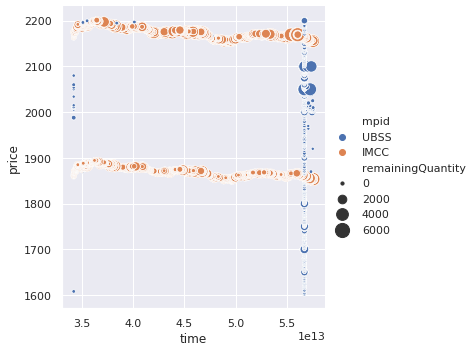

In [20]:
cleanedMPIDPositions = MPIDPositions.loc[(MPIDPositions['price']>16010320) &(MPIDPositions['price']<22012400), : ]
cleanedMPIDPositions['price'] = cleanedMPIDPositions['price'] / 10000
g=sns.relplot(x="time", y="price", size="remainingQuantity", hue='mpid', sizes=(10,200), data=cleanedMPIDPositions)


The figure shows that the strategies of IMCC and UBSS are obviously different. IMCC keeps updating the meaningful quotes (i.e close to market at 1-99 percentile of the mpid order's price range) over the day, while UBSS does the modification morely at the beginning and end of the day. 